In [1]:
%cd /home/thucth/thucth/project/image_classreg

/home/thucth/thucth/project/image_classreg


## Prepare dataset

```
Create csv file with path _ label(float score)

Description:
- Dataset with multi level:
0: no occlusion (or occluded area is out of id)
1: 10% occlusion
2: 20% occlusion
3: 30% occlusion
4: 40% occlusion
5: 50% occlusion
.
.
```

### Inherit data from IQ006

In [2]:
import pandas as pd
import json 
categories_new = [
    {"id": 1, "name": 'corner_1'},
    {"id": 2, "name": 'corner_2'},
    {"id": 3, "name": 'corner_3'},
    {"id": 4, "name": 'corner_4'},
    {"id": 5, "name": 'full'}
]

categories_map = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'full': 5
}

categories_map_inverse = {
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "full"
}


In [3]:
import json
def read_from_cocojson(path_json):
    images_dict={}
    with open(path_json, 'r') as f:
        data = json.load(f)
        for ann in data['annotations']:
            if ann["image_id"] not in images_dict:
                images_dict[ann["image_id"]]={"bbox":{}}
            corner_type = categories_map_inverse[ann["category_id"]]
            #this is to convert from coco format into voc format
            images_dict[ann["image_id"]]["bbox"][corner_type] = [ann["bbox"][0], ann["bbox"][1], ann["bbox"][2]+ann["bbox"][0], ann["bbox"][3]+ann["bbox"][1]]

        for img in data['images']:
            images_dict[img['id']]["path"]= img["file_name"]
            images_dict[img['id']]["width"] = img["width"]
            images_dict[img['id']]["height"] = img["height"]
    voc_data = [images_dict[k] for k in images_dict.keys()]
    return voc_data

### generate clear id

In [6]:
import csv
def generate_data_clear(voc_data, path_csv):
    print("Amount of source: ", len(voc_data))
    count=0
    f = open(path_csv, 'w')
    csv_writer = csv.writer(f)
    csv_writer.writerow(['path','score'])
    for sample in voc_data:
        if  len(sample['bbox'].keys())==5: #full corner
            csv_writer.writerow([sample['path'], 0])
            count+=1
    print("Amount of target: ", count)
    f.close()

split='val'
voc_data = read_from_cocojson(path_json = "/home/thucth/thucth/project/id_fullcorner_dataprocess/json_data/original_size_%s_2702.json"%split)
generate_data_clear(voc_data, "resources/data_occlusion_%s_clear.csv"%split)

Amount of source:  950
Amount of target:  858


### generate occluded id

In [5]:
split="val"
from src.datasets import augment
import cv2
import os
import importlib
importlib.reload(augment)
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
random.seed(1101)
voc_data = read_from_cocojson(path_json = "/home/thucth/thucth/project/id_fullcorner_dataprocess/json_data/original_size_%s_2702.json"%split)
df_id_clear = pd.read_csv("resources/data_occlusion_%s_clear.csv"%split)
path_backgrounds = list(df_id_clear['path'].values)
random.shuffle(path_backgrounds)

backegrounds=[]
backegrounds = augment.load_background(path_backgrounds, backegrounds) #use ref pass because we can disrupt but still have data
global_index=0
len_bg = len(backegrounds)
path2bbox={}
for sample_meta in tqdm(voc_data):
    path_image = os.path.basename(sample_meta['path'])
    bbox = sample_meta['bbox']
    path2bbox[path_image]=bbox  

100%|██████████| 950/950 [00:00<00:00, 99106.80it/s]


libpng warning: iCCP: known incorrect sRGB profile


too many indices for array: array is 2-dimensional, but 3 were indexed
./resources/fg-large/pngtree-black-particle-noise-floor-image_2252658.jpg
too many indices for array: array is 2-dimensional, but 3 were indexed
./resources/fg-large/pngtree-noise-tv-pixel-gray-texture-background-image_903604222233.png


libpng warning: iCCP: known incorrect sRGB profile


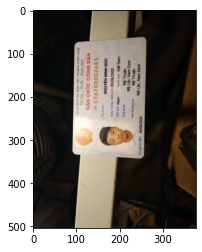

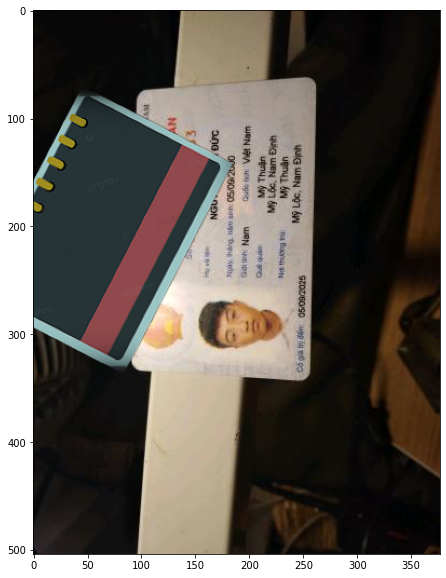

In [113]:
importlib.reload(augment)
# foregrounds = augment.load_foreground(path="./resources/fg-hand")
# percent = 0.8

foregrounds = augment.load_foreground(path="./resources/fg-large")
percent = 0.9

# foregrounds = augment.load_foreground(path="./resources/fg-small")
# percent = 0.05

img, name = backegrounds[2]
bbox = path2bbox[name]

plt.imshow(img)
plt.show()

c1 = augment.get_center(bbox['1'])
c2 = augment.get_center(bbox['2'])
dy = (c2[1]-c1[1])
dx = (c2[0]-c1[0])+1e-5
theta = math.atan(dy/dx)
if dx<0: theta+=math.pi

rotated_img, angle, pad_h, pad_w, rot_mat = augment.padrotate_image(img, theta*180/math.pi)

corners = [augment.get_center(bbox[str(i)]) for i in range(1, 5)]
corners_trans = np.array(corners)
corners_trans[:, 0] += pad_w
corners_trans[:, 1] += pad_h

corners_rotated = np.array(corners_trans)@rot_mat[:, :2].T
corners_rotated += rot_mat[:, 2]
corners_rotated = corners_rotated.astype(int)

empty_bg = np.zeros((*rotated_img.shape[:2],4), dtype=np.int16)

output = augment.process_wrapper(empty_bg, \
    foregrounds, \
    percent=percent, \
    # location_percent=(1.1,1.3, 0., 0.01), \
    location_percent=(0., 0.01, 1.4,1.5), \
    corners=corners_rotated, \
    is_debug=False)

# output,_ = augment.process(empty_bg, \
#     foregrounds[0], \
#     percent=percent, \
#     corners=corners_rotated, \
#     is_debug=True)


inv_fg = augment.unpadrotate_image(output, -angle, pad_h, pad_w)

# inv_fg[inv_fg[:,:,-1] == 0] = img[inv_fg[:,:,-1] == 0]

img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
img = img.astype(np.int16)
inv_fg = inv_fg.astype(np.int16)

alpha_channel = inv_fg[:,:,-1]
alpha_channel[alpha_channel>100] = 255
alpha_channel = cv2.GaussianBlur(alpha_channel,ksize=(3,3), sigmaX=0.5,sigmaY=0.5)
alpha_channel = alpha_channel[:,:,None]

img[:,:,:3] = inv_fg[:,:,:3]*(alpha_channel/255) +  img[:,:,:3]*((255-alpha_channel)/255)
img = img.astype(np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()


In [417]:
importlib.reload(augment)
global_index = 0
len_bg = len(backgrounds)


def gen_data(amount, percent, foregrounds_path, dir_store, csv_file, score=None, location_percent=(0., 1., 0., 1.)):
    global backgrounds
    global global_index
    os.makedirs(dir_store, exist_ok=True)
    if not os.path.exists(csv_file):
        f = open(csv_file, 'w')
        csv_writer = csv.writer(f)
        csv_writer.writerow(['path', 'score'])
    else:
        f = open(csv_file, 'a+')
        csv_writer = csv.writer(f)

    if score is None:
        score = percent*100

    foregrounds = augment.load_foreground(path=foregrounds_path)
    err_paths = []
    for _ in tqdm(range(amount)):
        global_index += 1
        img, name = backgrounds[global_index % len_bg]
        bbox = path2bbox[name]

        c1 = augment.get_center(bbox['1'])
        c2 = augment.get_center(bbox['2'])
        dy = (c2[1]-c1[1])
        dx = (c2[0]-c1[0])+1e-5
        theta = math.atan(dy/dx)
        if dx < 0:
            theta += math.pi

        rotated_img, angle, pad_h, pad_w, rot_mat = augment.padrotate_image(img, theta*180/math.pi)

        corners = [augment.get_center(bbox[str(i)]) for i in range(1, 5)]
        corners_trans = np.array(corners)
        corners_trans[:, 0] += pad_w
        corners_trans[:, 1] += pad_h

        corners_rotated = np.array(corners_trans)@rot_mat[:, :2].T
        corners_rotated += rot_mat[:, 2]
        corners_rotated = corners_rotated.astype(int)
        try:
            empty_bg = np.zeros((*rotated_img.shape[:2], 4), dtype=np.int16)
            output = augment.process_wrapper(empty_bg,
                                             foregrounds,
                                             percent=percent,
                                             location_percent=location_percent,
                                             corners=corners_rotated,
                                             is_debug=False)

        except Exception as e:
            print(e)
            err_paths.append(global_index)
            continue
        inv_fg = augment.unpadrotate_image(output, -angle, pad_h, pad_w)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
        img = img.astype(np.int16)
        inv_fg = inv_fg.astype(np.int16)

        alpha_channel = inv_fg[:, :, -1]
        alpha_channel[alpha_channel > 100] = 255
        alpha_channel = cv2.GaussianBlur(alpha_channel, ksize=(3, 3), sigmaX=0.5, sigmaY=0.5)
        alpha_channel = alpha_channel[:, :, None]

        img[:, :, :3] = inv_fg[:, :, :3]*(alpha_channel/255) + img[:, :, :3]*((255-alpha_channel)/255)
        img = img.astype(np.uint8)

        #write results
        idx_ext = name.rfind('.')
        name_store = name[:idx_ext] + '_%s' % int(score) + name[idx_ext:]

        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        cv2.imwrite(os.path.join(dir_store, name_store), img[:, :, ::-1])

        csv_writer.writerow([os.path.join(dir_store, name_store), int(score)])
    f.close()
    return err_paths


In [ ]:
# %%
percent = 0.3

output_temp = "/share/team/thucth/data/image_classreg/data_occlusion_%s_%s_0727" % (split, str(int(percent*100))+"_out")
dir_store = output_temp
csv_file = output_temp.replace("/share/team/thucth/data/image_classreg", "./resources")+".csv"

err_paths = gen_data(amount=2000,
                     percent=percent,
                     location_percent=(1.3, 1.7, 1.3, 1.7),
                     score=0.,
                     foregrounds_path="./resources/fg-hand",
                     dir_store=dir_store,
                     csv_file=os.path.abspath(csv_file))
print(len(err_paths))
print(dir_store)
print(csv_file)


In [411]:
percent = 0.2

output_temp = "/share/team/thucth/data/image_classreg/data_occlusion_%s_%s_0727" % (split, str(int(percent*100)))
dir_store = output_temp
csv_file = output_temp.replace("/share/team/thucth/data/image_classreg", "./resources")+".csv"


err_paths = gen_data(amount=2000,
                     percent=percent,
                     location_percent=(0.5, 1.1, 0.5, 1.1),
                     foregrounds_path="./resources/fg-small",
                     dir_store=dir_store,
                     csv_file=os.path.abspath(csv_file))
print(len(err_paths))
print(dir_store)
print(csv_file)


/share/team/thucth/data/image_classreg/data_occlusion_train_5
/home/thucth/thucth/project/image_classreg/resources/data_occlusion_train_5.csv


## Concat datasets

In [5]:
import pandas as pd
from tqdm import tqdm

In [6]:
split="train"
paths = ["./resources/data_occlusion_%s_clear.csv"%split, \
    "./resources/data_occlusion_%s_5.csv"%split, \
    "./resources/data_occlusion_%s_20.csv"%split, \
    "./resources/data_occlusion_%s_40.csv"%split, \
    "./resources/data_occlusion_%s_60.csv"%split, \
    "./resources/data_occlusion_%s_80.csv"%split, \
    "./resources/data_occlusion_%s_90.csv"%split, \
    "./resources/data_occlusion_%s_5_0727.csv"%split, \
    "./resources/data_occlusion_%s_20_0727.csv"%split, \
    "./resources/data_occlusion_%s_40_0727.csv"%split, \
    "./resources/data_occlusion_%s_60_0727.csv"%split, \
    "./resources/data_occlusion_%s_80_0727.csv"%split, \
    "./resources/data_occlusion_%s_90_0727.csv"%split, \
    "./resources/data_occlusion_%s_30_out_0727.csv"%split, \
    "./resources/data_occlusion_%s_40_out_0727.csv"%split
    ]
df = pd.read_csv(paths[0])
for path in tqdm(paths[1:]):
    print(len(df))
    df = pd.concat([df, pd.read_csv(path)], axis=0, ignore_index=True)

df.to_csv("./resources/data_occlusion_%s_0728.csv"%split, index=False)

100%|██████████| 14/14 [00:00<00:00, 142.56it/s]


24464
25461
26461
27459
29457
30457
32457
34456
36456
38455
42454
44453
48451
50448
